# GRN between Cell Types

This Notebook is part of the Bachelorthese from David Wild.

The goal of this notebook is to find out gene-gene interactions between different cell types. We want as a result a GRN that not only describes which genes express which, but also how much (weighted graph) and in which direction (exhibiting, inhibiting).  
Another aspect that would be interesting are finding co-factors.


In [1]:
try:
    # Check if this gets executed in google colab. 
    # If so, then we need to install pip packages and clone the repo and data
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

In [2]:
if IN_COLAB:
    !pip install scanpy
    !pip install torch
    !pip install matplotlib
    !pip install pandas
    !pip install numpy
    !pip install -U -q PyDrive
else:
    !pip install -r requirements.txt

/bin/bash: line 1: /home/atr0x/Documents/UNI/WS2025/BachelorArbeit/GAE-gene-interactions/.venv/bin/pip: cannot execute: required file not found


In [3]:
if IN_COLAB:
    !git clone https://github.com/DavidWild02/BachelorThesis-ML-Gene-Interactions.git
    %cd ./BachelorThesis-ML-Gene-Interactions

In [4]:
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    !cp -r /content/drive/MyDrive/DavidWildBachelorthesis/data .

In [5]:
import scanpy as sc
import pandas as pd
import numpy as np

adata = sc.read_h5ad("./data/subdom_processed.h5ad")
adata

AnnData object with n_obs × n_vars = 2671 × 13144
    obs: 'n_genes_by_counts', 'total_counts', 'clusters', 'ct_num_exp_genes', 'ct_score', 'ct_pseudotime'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std', 'ct_gene_corr', 'ct_correlates'
    uns: 'clusters_colors', 'clusters_sizes', 'ct_params', 'hvg', 'leiden', 'log1p', 'neighbors', 'paga', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'Ms', 'Mu', 'log_tpm', 'spliced', 'tpm', 'unspliced'
    obsp: 'connectivities', 'distances'

In [6]:
adata.to_df().head()

,SUB2.g1,SUB2.g2,SUB2.g3,SUB2.g4,SUB2.g5,SUB2.g6,SUB2.g7,SUB2.g8,SUB2.g9,SUB2.g10,...,SUB2.g13135,SUB2.g13136,SUB2.g13137,SUB2.g13138,SUB2.g13139,SUB2.g13140,SUB2.g13141,SUB2.g13142,SUB2.g13143,SUB2.g13144
AAACCCAAGGACAGCT-1,0.009687,-1.032545,-1.566363,1.018223,-0.933981,-0.410398,-0.349553,-0.444472,-0.132447,-0.567418,...,0.0,0.0,0.0,-0.293056,0.0,0.0,0.0,0.0,-0.365098,-0.652811
AAACCCAAGGGTTTCT-1,1.598354,-0.300789,-0.202161,-0.002592,0.181964,0.269252,-0.393041,0.037609,0.115123,-0.754939,...,0.0,0.0,0.0,-0.192047,0.0,0.0,0.0,0.0,-0.296943,-0.677305
AAACCCACAAATGGTA-1,-0.777102,-0.792809,-1.281675,1.262175,-0.185155,-0.726397,-0.455605,-0.671795,-0.448440,-0.868259,...,0.0,0.0,0.0,-0.315716,0.0,0.0,0.0,0.0,-0.205751,0.327006
AAACCCATCGAGAAGC-1,0.696619,-0.306533,0.700373,-1.587061,-0.054666,0.263420,-0.105024,0.250046,0.661372,-0.186924,...,0.0,0.0,0.0,-0.300775,0.0,0.0,0.0,0.0,-0.310817,-0.878208
AAACCCATCTTGTTAC-1,-1.319795,-1.191836,-1.658409,1.626106,-0.142163,-1.176196,-0.391015,-0.537126,-0.254368,-0.777899,...,0.0,0.0,0.0,-0.301799,0.0,0.0,0.0,0.0,-0.303617,-0.420889


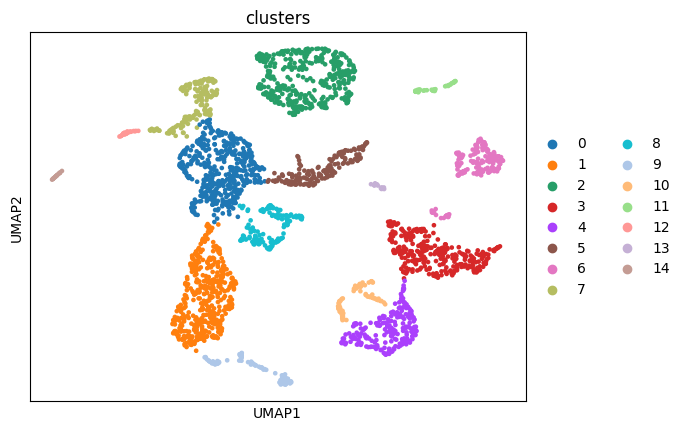

In [7]:
sc.pl.umap(adata, color="clusters")

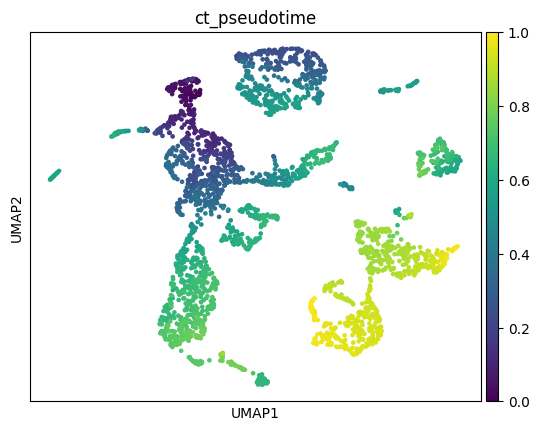

In [8]:
sc.pl.umap(adata, color="ct_pseudotime")

In the data set the data is already preprocessed, clustered and also the pseudo-time was calculated on it. The pseudo-time is a time approximation, measured on how specified the cell is in terms of how many genes are expressed. The idea is that more specialized cells have fewer expressed genes.

We already have a GRN, but it is global, we would prefer a single GRN for each cell-type to cell-type transition. Also we want a weighted GRN and the GRN at the moment is a binary matrix.
One method to construct such GRNs is by just using a Masked Linear Regression. The weight matrix of this linear regression would then be the adjacency matrix of the GRN.

To look if the approach is feasible at all, we will first only do that for stem cells (cluster 7) to transition cells (cluster 0).  
After that we validate how well prediction is (accuracy, residual plot) and how well the GRN correlates to existing knowledge.
Also how non linear models like Neural networks perform in comparison.

In [9]:
from IPython.display import display

#  load data global GRN
df_grn = pd.read_csv("./data/transcription_factor_adjacency_matrix.csv", index_col="gene_ids")
print("transcription factor adjacency matrix")
df_grn = df_grn.transpose()
display(df_grn.head())

transcription factor adjacency matrix


gene_ids,SUB2.g1,SUB2.g2,SUB2.g11,SUB2.g16,SUB2.g18,SUB2.g21,SUB2.g22,SUB2.g26,SUB2.g27,SUB2.g31,...,SUB2.g12978,SUB2.g12979,SUB2.g12980,SUB2.g13052,SUB2.g13056,SUB2.g13090,SUB2.g13093,SUB2.g13119,SUB2.g13123,SUB2.g13134
SUB2.g8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SUB2.g231,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
SUB2.g755,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
SUB2.g902,1,1,1,0,0,0,0,0,0,0,...,0,0,1,1,1,0,0,0,0,0
SUB2.g924,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,1,1


The Linear Regression should take samples from cluster A and predict samples in cluster B. The mappings a->b are sampled randomly.  
Of course this approach could be enhanced with other techniques, that search for a better mapping. Like Optimal Transport for example.

In [10]:
from typing import Iterator, Tuple
from torch.utils.data import Sampler

np.random.seed(42) # set seed to make reproducible outputs

class RandomMappingSampler(Sampler):
    def __init__(self, data_a: np.ndarray, data_b: np.ndarray):
        self._data_A = data_a
        self._data_B = data_b
        super().__init__()

    def __iter__(self) -> Iterator[Tuple[int, int]]:
        while True:
            index_A = np.random.randint(0, self._data_A.shape[0])
            index_B = np.random.randint(0, self._data_B.shape[0])
            # a sampler should just return the indices and not the samples
            yield index_A, index_B



In [11]:
from itertools import islice
from typing import Type
from sklearn.model_selection import GridSearchCV
from MaskedRidgeRegressor import MaskedRidgeRegressor

# TODO: let num_samples also be a float. in that case it should sample a percentage of all possible associations a*b
def sample_associations(samples_cluster_a: np.ndarray, samples_cluster_b: np.ndarray, 
                        sampler, num_samples=1000, **kwargs):
    sample_indices = list(islice(iter(sampler), num_samples))
    sample_indices_a = list(map(lambda x: x[0], sample_indices))
    sample_indices_b = list(map(lambda x: x[1], sample_indices))

    X = samples_cluster_a[sample_indices_a]
    y = samples_cluster_b[sample_indices_b]

    return X, y

def create_grn_for_cluster_to_cluster_association(samples_cluster_a: np.ndarray, samples_cluster_b: np.ndarray, mask_grn: np.ndarray, sampler=None):
    if sampler is None:
        sampler = RandomMappingSampler(samples_cluster_a, samples_cluster_b)
    X, y = sample_associations(samples_cluster_a, samples_cluster_b, sampler)

    param_grid = {
        "lr": [0.1, 0.01]
    }

    model = MaskedRidgeRegressor(mask_grn, epochs=500)
    grid_search = GridSearchCV(model, param_grid, cv=4)
    grid_search.fit(X, y)
    best_estimator = grid_search.best_estimator_
    print("best parameters:", grid_search.best_params_)
    print("best score:", grid_search.best_score_)

    return best_estimator.W_


In [12]:
def extract_samples_of_cell_cluster(adata, cluster_id: str) -> pd.DataFrame:
    obs_mask_cell_cluster = adata.obs["clusters"].values == cluster_id
    samples_cell_cluster = adata.X[obs_mask_cell_cluster, :]
    df_stem_cells = pd.DataFrame(samples_cell_cluster,
                                        index=adata.obs_names[obs_mask_cell_cluster],
                                        columns=adata.var_names)
    return df_stem_cells

stem_cells_cluster_id = '7'
transition_cells_cluster_id = '0'

df_stem_cells = extract_samples_of_cell_cluster(adata, stem_cells_cluster_id)
df_transition_cells = extract_samples_of_cell_cluster(adata, transition_cells_cluster_id)

print(f"Shape of stem cells: {df_stem_cells.shape}")
print(f"Shape of transition cells: {df_transition_cells.shape}")

Shape of stem cells: (151, 13144)
Shape of transition cells: (453, 13144)


In [13]:

grn_mask = df_grn.values
stem_cells_cluster = df_stem_cells[df_grn.index].values
transition_cell_cluster = df_transition_cells[df_grn.columns].values
weighted_grn = create_grn_for_cluster_to_cluster_association(stem_cells_cluster, transition_cell_cluster, grn_mask)
df_weighted_grn = pd.DataFrame(weighted_grn, index=df_grn.index, columns=df_grn.columns)
df_weighted_grn.head()

Epoch 499: 100%|██████████| 500/500 [00:17<00:00, 28.40it/s, loss=0.263]


best parameters: {'lr': 0.1}
best score: -0.008678786107338965


gene_ids,SUB2.g1,SUB2.g2,SUB2.g11,SUB2.g16,SUB2.g18,SUB2.g21,SUB2.g22,SUB2.g26,SUB2.g27,SUB2.g31,...,SUB2.g12978,SUB2.g12979,SUB2.g12980,SUB2.g13052,SUB2.g13056,SUB2.g13090,SUB2.g13093,SUB2.g13119,SUB2.g13123,SUB2.g13134
SUB2.g8,-0.000000,-0.000000,-0.000000,0.0,-0.0,-0.000000,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,0.000000e+00,-0.000000,-0.000000,-0.000000,-0.0,-0.000000,-0.000000,0.00000
SUB2.g231,0.000000,0.000000,0.000000,-0.0,-0.0,0.000228,0.0,0.0,0.0,0.0,...,-0.0,-0.0,-0.000000e+00,-0.000000,-0.000504,0.003749,-0.0,0.000000,0.000000,0.00000
SUB2.g755,-0.000000,0.000000,-0.005220,-0.0,-0.0,-0.000000,-0.0,0.0,-0.0,-0.0,...,-0.0,0.0,-0.000000e+00,0.000676,-0.000000,0.000000,-0.0,0.000000,0.000000,0.00000
SUB2.g902,-0.003712,0.002467,0.002092,0.0,0.0,-0.000000,-0.0,-0.0,-0.0,-0.0,...,0.0,0.0,1.013658e-11,-0.000457,-0.000763,-0.000000,0.0,0.000000,-0.000000,0.00000
SUB2.g924,0.000000,-0.000000,-0.001371,0.0,-0.0,-0.000000,0.0,0.0,0.0,-0.0,...,-0.0,0.0,0.000000e+00,0.000000,0.000000,-0.002858,-0.0,-0.001163,0.001394,-0.00391


To validate how good the regression model explains the data we use the R2-Score.

$$
R^2 = 1 - \frac{\sum{\left( y - \hat{y} \right)^2}}{\sum{\left( y - \overline{y} \right)^2}}
$$

The R2-Score can range from 1 to -1:
- 1 means that the model predicts perfectly the data.
- 0 means the model does not better than predicting the average
- -1 means the model does worse than predicting the average

From the output below we can see, that the regression for most genes outputs a R2-score of nearly 0. That means our model predicts the average. This was as expected, because we randomly sample associations between X and y. So which cells of A (stem cells) "evolve" to cells of B (transition cells).

Some genes have a very bad score (negative). This means that probably some explanatory variables are missing or that the relationship is non linear. 

In [14]:
from sklearn.metrics import r2_score
import seaborn as sns
import matplotlib.pyplot as plt

sampler = RandomMappingSampler(stem_cells_cluster, transition_cell_cluster)
X, y = sample_associations(stem_cells_cluster, transition_cell_cluster, sampler, num_samples=100)
y_pred = X @ weighted_grn

genes_r2_score = [ r2_score(y[:, i], y_pred[:, i]) for i in range(y.shape[1])]

genes_r2_score = np.array([genes_r2_score]).T
df_gen_scores = pd.DataFrame(genes_r2_score, index=df_grn.columns, columns=["r2_score"])
df_gen_scores = df_gen_scores.sort_values(by="r2_score", ascending=False)
display(df_gen_scores.head())
display(df_gen_scores.tail())


,r2_score
gene_ids,
SUB2.g11253,1.000000
SUB2.g3821,0.013534
SUB2.g5059,0.006823
SUB2.g5871,0.006811
SUB2.g2358,0.006522


,r2_score
gene_ids,
SUB2.g5908,-303.822754
SUB2.g11633,-340.841400
SUB2.g12623,-945.658386
SUB2.g10238,-7927.008789
SUB2.g4797,-10439.409180


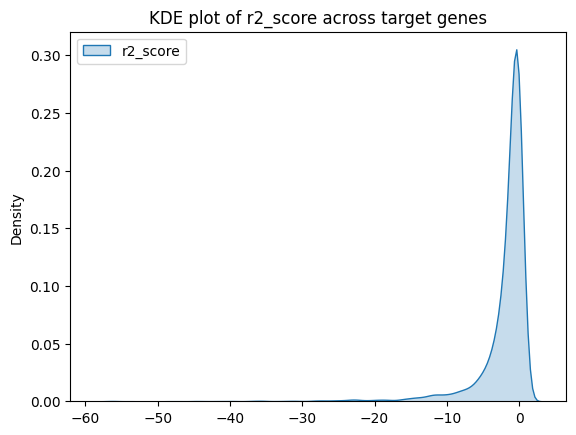

In [15]:
df_gen_scores_lower_quantile = df_gen_scores["r2_score"].quantile(0.005)
df_gen_scores_without_outliers = df_gen_scores[df_gen_scores["r2_score"] >= df_gen_scores_lower_quantile]

plt.title("KDE plot of r2_score across target genes")
sns.kdeplot(df_gen_scores_without_outliers, fill=True)
plt.show()

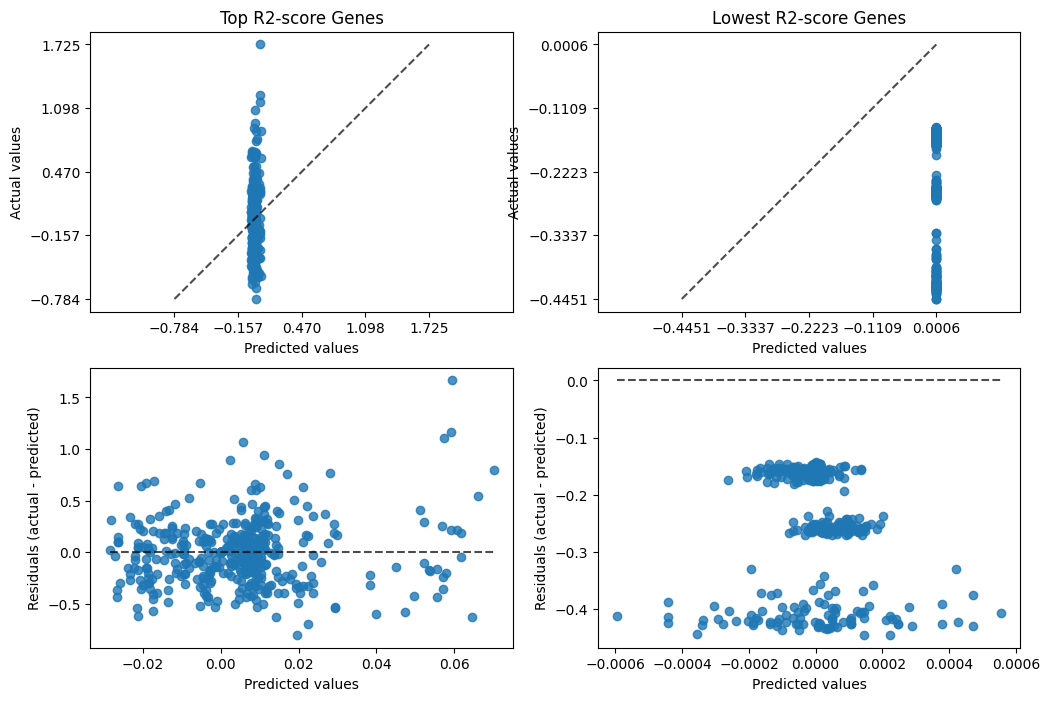

In [16]:
from sklearn.metrics import PredictionErrorDisplay


y_top_r2_score_mask = df_grn.columns.isin(df_gen_scores.head().index)
y_bottom_r2_score_mask = df_grn.columns.isin(df_gen_scores.tail().index)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

axes[0, 0].set_title("Top R2-score Genes")
PredictionErrorDisplay.from_predictions(y[:, y_top_r2_score_mask], y_pred[:, y_top_r2_score_mask], 
                                        kind='actual_vs_predicted',
                                        ax=axes[0, 0])
PredictionErrorDisplay.from_predictions(y[:, y_top_r2_score_mask], y_pred[:, y_top_r2_score_mask], 
                                        kind='residual_vs_predicted',
                                        ax=axes[1, 0])

axes[0, 1].set_title("Lowest R2-score Genes")
PredictionErrorDisplay.from_predictions(y[:, y_bottom_r2_score_mask], y_pred[:, y_bottom_r2_score_mask],
                                        kind='actual_vs_predicted',
                                        ax=axes[0, 1])
PredictionErrorDisplay.from_predictions(y[:, y_bottom_r2_score_mask], y_pred[:, y_bottom_r2_score_mask], 
                                        kind='residual_vs_predicted',
                                        ax=axes[1, 1])

Now I want to try a better sampling method. Instead of only randomly sampling A->B associations, I want to filter them so that only those are chosen, who are similar far apart in pseudo-time. 

<Axes: xlabel='ct_pseudotime', ylabel='Density'>

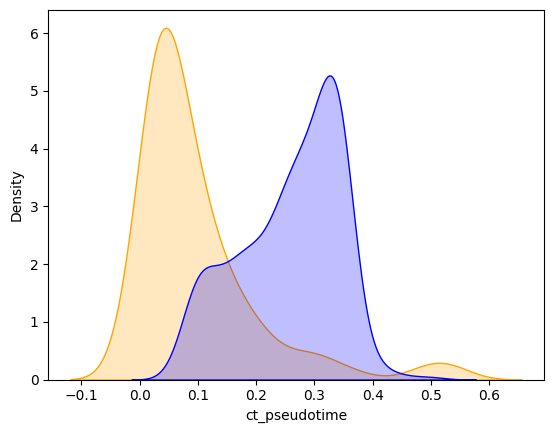

In [17]:
df_pseudo_time_stem_cells = adata.obs["ct_pseudotime"][df_stem_cells.index]
df_pseudo_time_transition_cells = adata.obs["ct_pseudotime"][df_transition_cells.index]

sns.kdeplot(df_pseudo_time_stem_cells, color="orange", fill=True)
sns.kdeplot(df_pseudo_time_transition_cells, color="blue", fill=True)

first approach - distance kernel for probability

In [18]:
import scipy

class WeightedDistanceMappingSampler(Sampler):
    def __init__(self, data_a, data_b, distance, variance, delta):
        self._data_a = data_a
        self._data_b = data_b
        self._delta = delta
        self._kernel = scipy.stats.norm(distance, np.sqrt(variance))
        self._max_likelihood = self._kernel.pdf(distance) 
        self._random_sampler = iter(RandomMappingSampler(self._data_a, self._data_b))
        super().__init__()

    def __iter__(self) -> Iterator[Tuple[int, int]]:
        while True:
            index_a, index_b = next(self._random_sampler)

            distance = np.abs(self._data_a[index_a] - self._data_b[index_b]) # l1-norm
            probability = self._kernel.cdf(distance + self._delta) - self._kernel.cdf(distance - self._delta)
            if np.random.uniform(0., 1.) < probability:
                continue

            yield index_a, index_b

In [19]:
distance = np.abs(df_pseudo_time_stem_cells.mean() - df_pseudo_time_transition_cells.mean())
variance = (df_pseudo_time_stem_cells.to_numpy().var() + df_pseudo_time_stem_cells.to_numpy().var()) / 2
delta = 0.1 * np.sqrt(variance)
sampler = WeightedDistanceMappingSampler(df_pseudo_time_stem_cells.to_numpy(), df_pseudo_time_transition_cells.to_numpy(), distance, variance, delta)
weighted_grn = create_grn_for_cluster_to_cluster_association(stem_cells_cluster, transition_cell_cluster, grn_mask, sampler=sampler)
df_weighted_grn = pd.DataFrame(weighted_grn, index=df_grn.index, columns=df_grn.columns)
df_weighted_grn.head()

Epoch 499: 100%|██████████| 500/500 [00:17<00:00, 27.83it/s, loss=0.268]


best parameters: {'lr': 0.1}
best score: -0.00514250883134082


gene_ids,SUB2.g1,SUB2.g2,SUB2.g11,SUB2.g16,SUB2.g18,SUB2.g21,SUB2.g22,SUB2.g26,SUB2.g27,SUB2.g31,...,SUB2.g12978,SUB2.g12979,SUB2.g12980,SUB2.g13052,SUB2.g13056,SUB2.g13090,SUB2.g13093,SUB2.g13119,SUB2.g13123,SUB2.g13134
SUB2.g8,-0.000000,-0.000000,-0.000000,-0.0,0.0,0.000000,0.0,-0.0,0.0,0.0,...,0.0,0.0,-0.000000e+00,0.000000,-0.000000,-0.000000,-0.0,-0.000000,-0.000000,0.000000
SUB2.g231,-0.000000,-0.000000,-0.000000,0.0,-0.0,0.003404,0.0,0.0,0.0,0.0,...,0.0,-0.0,-0.000000e+00,-0.000000,0.000576,-0.001234,-0.0,-0.000000,0.000000,-0.000000
SUB2.g755,0.000000,0.000000,0.001099,-0.0,-0.0,-0.000000,0.0,0.0,0.0,-0.0,...,0.0,-0.0,-0.000000e+00,0.000413,-0.000000,0.000000,0.0,0.000000,0.000000,-0.000000
SUB2.g902,0.000283,-0.001879,-0.001907,0.0,0.0,-0.000000,0.0,0.0,0.0,0.0,...,-0.0,0.0,-6.061605e-12,-0.000036,0.000681,0.000000,-0.0,0.000000,0.000000,-0.000000
SUB2.g924,0.000000,0.000000,0.000952,0.0,-0.0,-0.000000,0.0,0.0,0.0,0.0,...,-0.0,-0.0,0.000000e+00,0.000000,-0.000000,0.004791,-0.0,-0.000925,0.000273,-0.001065


In [20]:
sampler = WeightedDistanceMappingSampler(df_pseudo_time_stem_cells.to_numpy(), df_pseudo_time_transition_cells.to_numpy(), distance, variance, delta)
X, y = sample_associations(stem_cells_cluster, transition_cell_cluster, sampler, num_samples=100)
y_pred = X @ weighted_grn

genes_r2_score = [ r2_score(y[:, i], y_pred[:, i]) for i in range(y.shape[1])]

genes_r2_score = np.array([genes_r2_score]).T
df_gen_scores = pd.DataFrame(genes_r2_score, index=df_grn.columns, columns=["r2_score"])
df_gen_scores = df_gen_scores.sort_values(by="r2_score", ascending=False)
display(df_gen_scores.head())
display(df_gen_scores.tail())

,r2_score
gene_ids,
SUB2.g11253,1.000000
SUB2.g9531,0.006621
SUB2.g5344,0.006437
SUB2.g478,0.006134
SUB2.g7210,0.005851


,r2_score
gene_ids,
SUB2.g1911,-334.057617
SUB2.g11633,-474.152710
SUB2.g12623,-1385.467163
SUB2.g4797,-8947.569336
SUB2.g10238,-11438.747070


second approach - add links for self inhibition / exhibition